In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Activation, Input, LeakyReLU,RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from sklearn.model_selection import train_test_split
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import pydotplus as pyd
import keras
from keras.utils import vis_utils
vis_utils.pydot = pyd
from google.colab import drive

drive.mount('drive')

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


Saving akarsu_relevant_acısu.csv to akarsu_relevant_acısu.csv
User uploaded file "akarsu_relevant_acısu.csv" with length 9393 bytes


In [ ]:
def truncate(x, feature_cols, target_cols, TIME_STEPS_TRAIN, TIME_STEPS_TEST):
    print(type(feature_cols))
    print(feature_cols)
    print(type(target_cols))
    print(target_cols)
    in_, out_ = [], []
    for i in range(len(x) - TIME_STEPS_TRAIN - TIME_STEPS_TEST + 1):
        in_.append(x.iloc[i:(i + TIME_STEPS_TRAIN)].values.tolist())
        out_.append(x.iloc[(i + TIME_STEPS_TRAIN):(i + TIME_STEPS_TRAIN + TIME_STEPS_TEST)].values.tolist())

    return np.array(in_), np.array(out_)


        Date  Amonyum_Azotu  Askıda_Katı_Madde  Çözünmüş_Oksijen  \
0   7/1/2005        0.39000           22.50000           7.34000   
1   8/1/2005        0.10000           22.50000           7.03000   
2   9/1/2005        0.20000           22.50000           6.52000   
3  10/1/2005        0.30000           22.50000           8.24000   
4  11/1/2005        0.26000           22.50000           6.97000   

   Elektriksel_İletkenlik  Fekal_Koliform  Toplam_Koliform  Toplam_Fosfor  \
0               680.00000      1900.00000       2100.00000        0.10000   
1               680.00000      1100.00000       1300.00000        0.24000   
2               680.00000       500.00000        900.00000        0.22000   
3               680.00000       400.00000        800.00000        0.10000   
4               680.00000         0.00000        900.00000        0.10000   

   Toplam_Kjeldahl_Azotu  Toplam_Pestisit  Kimyasal_Oksijen_İhtiyacı      pH  \
0                0.57000          0.00010       

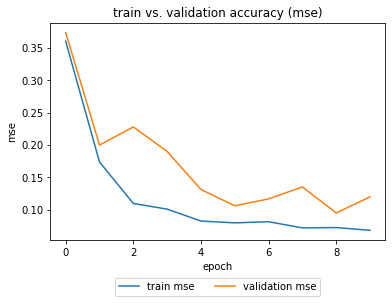

train_pred_detrend.shape, test_pred_detrend.shape:  (72, 1, 15) (18, 1, 15)
train_true_detrend.shape, test_true_detrend.shape:  (72, 1, 15) (18, 1, 15)
train pred shape:  (1080,)
train true shape:  (1080,)
test pred shape:  (270,)
test true shape:  (270,)


NameError: ignored

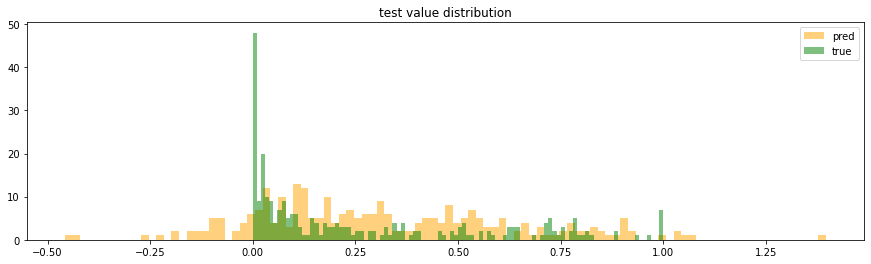

In [ ]:

akarsu_df = pd.read_csv('akarsu_relevant_acısu.csv',  low_memory=False)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#akarsu_cols = ['Fekal_Koliform', 'Toplam_Koliform', 'Toplam_Fosfor', 'Toplam_Kjeldahl_Azotu', 'Kimyasal_Oksijen_İhtiyacı', 'Nitrat_Azotu', 'Çözünmüş_Oksijen']


# Scale features
#akarsu_scaled = akarsu_df.copy()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
print(akarsu_df.head(5))
for i in akarsu_df.columns.drop('Date'):
    akarsu_scaled[[i]] = scaler.fit_transform(akarsu_df[[i]])

akarsu_scaled.index = pd.to_datetime(akarsu_scaled.index, yearfirst = True)
akarsu_df.index = pd.to_datetime(akarsu_df.index, yearfirst = True)
#print(df.describe())



n_timesteps = 8 # Length of the output sequences
n_hidden = 100
EPOCHS = 10
BATCH_SIZE = 4 # Number of timeseries samples in each batch

x_train = akarsu_scaled.drop('Date', axis=1)
akarsu_cols=akarsu_scaled.columns.drop('Date')
print(akarsu_cols)
x_train_max = x_train[:len(akarsu_cols)].max(axis=0)

print(x_train.head(5))

X_in, X_out = truncate(x_train, feature_cols=akarsu_cols,target_cols=akarsu_cols,TIME_STEPS_TRAIN=n_timesteps,
                       TIME_STEPS_TEST=1)

# Split the data into train and test parts using percentage of 0.8 and 0.2 respectively
X_input_train, X_input_test = train_test_split(X_in, test_size=0.2)
X_output_train, X_output_test = train_test_split(X_out, test_size=0.2)

print("X_input_train.shape, X_output_train.shape: ", X_input_train.shape, X_output_train.shape)
print("X_input_test.shape, X_output_test.shape: ", X_input_test.shape, X_output_test.shape)

# Create the model

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]))

print("input_train: ", input_train)
print("output_train: ", output_train)

encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
                                                           return_state=True, return_sequences=True)(input_train)

print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
print(encoder_last_h)

encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
print(encoder_last_c)

decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

context = dot([attention, encoder_stack_h], axes=[2, 1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

model = Model(inputs=input_train, outputs=out)
model.compile(loss=losses.MeanSquaredError(), optimizer='adam', metrics=['mse'])
model.summary()


es = EarlyStopping(monitor='val_loss', mode='min', patience=50)

#Fit the model
history = model.fit(X_input_train, X_output_train, batch_size=BATCH_SIZE, validation_split=0.2,epochs=EPOCHS, verbose=1, callbacks=[es])
train_mse = history.history['mse']
valid_mse = history.history['val_mse']

# Save the model
model_folder =".\results"

# The plot of architecture of the model
modelsavename = model_folder  + 'attention_model.png'
#plot_model(model, to_file=modelsavename, show_shapes=True, show_layer_names=True)

# Error and epoch plot
plt.plot(train_mse, label='train mse'),
plt.plot(valid_mse, label='validation mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mse)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plotname = '_train_vs_valid.png'
plt.savefig(plotname)
plt.show()

train_pred_detrend = model.predict(X_input_train)
test_pred_detrend = model.predict(X_input_test)
print("train_pred_detrend.shape, test_pred_detrend.shape: ", train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = X_output_train
test_true_detrend = X_output_test
print("train_true_detrend.shape, test_true_detrend.shape: ", train_true_detrend.shape, test_true_detrend.shape)

print("train pred shape: ", train_pred_detrend.flatten().shape)
print("train true shape: ", train_true_detrend.flatten().shape)

print("test pred shape: ", test_pred_detrend.flatten().shape)
print("test true shape: ", test_true_detrend.flatten().shape)

train_pred_plot = train_pred_detrend.flatten()
train_true_plot = train_true_detrend.flatten()
test_pred_plot = test_pred_detrend.flatten()
test_true_plot = test_true_detrend.flatten()

plt.figure(figsize=(15, 4))
plt.hist(test_pred_plot, bins=100, color='orange', alpha=0.5, label='pred')
plt.hist(test_true_plot, bins=100, color='green', alpha=0.5, label='true')
plt.legend()
plt.title('test value distribution')
plotname = str(savetime) + '_testpred_vs_testtrue.png'
plt.savefig(plotname)
plt.show()
    #####TEST#####
plt.figure(figsize=(15, 4))
plt.hist(train_pred_plot, bins=100, color='orange', alpha=0.5, label='pred'),
plt.hist(train_true_plot, bins=100, color='green', alpha=0.5, label='true')
plt.legend()
plt.title('train value distribution')
plotname = str(savetime) + '_trainpred_vs_traintrue.png'
plt.savefig(plotname)
plt.show()

'''MAE_overall = abs(test_pred_detrend - test_true_detrend).mean()
    MAE_ = abs(test_pred_detrend - test_true_detrend).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE TEST : overall MAE = ' + str(MAE_overall))
    plotname = str(savetime) + '_mae_test.png'
    plt.savefig(plotname)

    MAE_overall = abs(train_pred_detrend - train_true_detrend).mean()
    MAE_ = abs(train_pred_detrend - train_true_detrend).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE TRAIN : overall MAE = ' + str(MAE_overall))
    plotname = str(savetime) + '_mae_train.png'
    plt.savefig(plotname)
'''


